In [1]:
#
# Import Dataset
#

import os
from sklearn.datasets import load_files

DATA_SETS_PATH = 'data/data_sets'
DATA_SET_NAME = 'bbcsport'
CATEGORIES = ['athletics', 'cricket', 'football', 'rugby', 'tennis']

container_path = os.path.join(DATA_SETS_PATH, DATA_SET_NAME)
bunch = load_files(container_path=container_path, description=DATA_SET_NAME, categories=CATEGORIES, decode_error='ignore', encoding='utf-8')

In [2]:
#
# Helper Methods
#

import numpy as np

def get_dataset_info_string(dataset):
    """Ridiculous way to print out dataset info"""
    
    # count number of samples/documents in dataset
    num_docs = lambda i: list(zip(*np.unique(dataset.target, return_counts=True)))[i][1]
    
    # ordering of output
    display_column_order = ['Target', 'Target Name', 'Documents']
    
    # uses target as index
    column_param_funcs = {
        'Target' : lambda i: i,
        'Target Name' : lambda i: dataset.target_names[i],
        'Documents' : lambda i: num_docs(i)
    }
    
    column_names = list(column_param_funcs.keys())
    column_headers_dict = {column_name:column_name for column_name in column_names}
    column_values = zip(*[[v(i) for v in column_param_funcs.values()] for i in range(len(dataset.target_names))])

    # useful dictionaries 
    info_dict = [{k:v(i) for k,v in column_param_funcs.items()} for i in range(len(dataset.target_names))]
    merged_values_by_column = dict(zip(column_names, column_values))    
    
    # get maximum length string for each column name in dataset
    get_max_str_len = lambda list: max([len(str(i)) for i in list])
    max_header_len = {k: max(len(k),get_max_str_len(v)) for k,v in merged_values_by_column.items()}
    ordered_max_header_len = [(column_name, max_header_len[column_name]) for column_name in display_column_order] 
    
    # format output
    template = '|'.join(["{%s:%d}" % (column_name, max_len) for column_name, max_len in ordered_max_header_len])
    
    # create header
    header = template.format(**column_headers_dict)
    bar = '-'*(sum([o[1] for o in ordered_max_header_len]) + len(ordered_max_header_len))

    # add category info to display string
    description = dataset.DESCR
    if dataset.DESCR is None:
        description = "None"
    data_set_info_string = 'Dataset Description: \n' + dataset.DESCR + '\n' + bar + '\n' + header + '\n' + bar + '\n'
    for rec in info_dict: 
          data_set_info_string += template.format(**rec) + '\n'
    data_set_info_string += bar
    
    # add total number of documents to string
    total_documents = dataset.target.shape[0]
    data_set_info_string += "\nTotal Documents:\t" + str(total_documents)

            
    return data_set_info_string    

In [3]:
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import seaborn as sns

#
# Preproses Text, Convert Documents to Sequences, and One-Hot Encode Targets
#

# tokenize, build vocab and generate document sequences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(bunch.data)

sequences = tokenizer.texts_to_sequences(bunch.data)
word_index = tokenizer.word_index
VOCAB_SIZE = len(word_index)

y_ohe = keras.utils.to_categorical(bunch.target)

#
# display dataset info
#

print(get_dataset_info_string(bunch))
print("Vocabulary Size:\t" + str(VOCAB_SIZE))

#
# padding and clipping documents for reccurent network input
#

print("\nPad and limit inputs to RNN... \n")

# pad and clip
MAX_ART_LEN = 500
X = pad_sequences(sequences, maxlen=MAX_ART_LEN)

# display document lengths and stats
document_lengths = np.array([len(d) for d in sequences])
MAX_DOCUEMNT_LENGTH, mean_length, std_length = max(document_lengths), np.mean(document_lengths), np.std(document_lengths)

print("Maximum Document Length: %s (words)" % MAX_DOCUEMNT_LENGTH)
print("Mean Document Length: %s (words)" % mean_length)
print("STD Document Lengths: %s " % std_length)
sns.distplot(list(document_lengths), kde=False, rug=True);

# MAX_ART_LEN parameter effects
docs_covered = document_lengths[ np.where( document_lengths <= MAX_ART_LEN ) ]
percent_docs_covered = len(docs_covered)/len(document_lengths)
stds_covered = (MAX_ART_LEN - mean_length)/std_length

print("\nMaximum Document Length Allowed: %s (words)" % MAX_ART_LEN)
print("Chosen Document Length Parameter Effects...\n")
print("Percentage of Documents Within Limit: %s" % (percent_docs_covered*100))
print("STD's Covered: %s" % stds_covered)

# display final specs
print("\nEncoded Dataset Dimensions:\n")
print('Shape of Data Tensor:', X.shape)
print('Shape of Label Tensor:', y_ohe.shape)


Using TensorFlow backend.


Dataset Description: 
bbcsport
-----------------------------
Target|Target Name|Documents
-----------------------------
     0|athletics  |      101
     1|cricket    |      124
     2|football   |      265
     3|rugby      |      147
     4|tennis     |      100
-----------------------------
Total Documents:	737
Vocabulary Size:	14224

Pad and limit inputs to RNN... 

Maximum Document Length: 1724 (words)
Mean Document Length: 346.472184531886 (words)
STD Document Lengths: 190.3401998942172 

Maximum Document Length Allowed: 500 (words)
Chosen Document Length Parameter Effects...

Percentage of Documents Within Limit: 82.4966078697422
STD's Covered: 0.8065969015133854

Encoded Dataset Dimensions:

Shape of Data Tensor: (737, 500)
Shape of Label Tensor: (737, 5)


/anaconda3/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


In [4]:
#
# Seperate Train and Test Data
#

from sklearn.model_selection import train_test_split

TEST_2_SET_RATIO = 0.2
DOUGLAS_ADAMS = 42
NUM_CLASSES = len(bunch.target_names)

# Split it into train / test subsets
X_train, X_test, y_train_ohe, y_test_ohe = train_test_split(X, y_ohe, test_size=TEST_2_SET_RATIO,
                                                            stratify=bunch.target, 
                                                            random_state=DOUGLAS_ADAMS)
#
# display dataset train / test split info
#

print(get_dataset_info_string(bunch))

print("\nEncoded Dataset Dimensions:\n")
print('Shape of Data Tensor:', X.shape)
print('Shape of Label Tensor:', y_ohe.shape)

print("\nTrain Test Split: ", TEST_2_SET_RATIO)

print("\nTrain Dataset Dimensions:\n")
print('Shape of Data Tensor:', X_train.shape)
print('Shape of Label Tensor:', y_train_ohe.shape)

print("\nTest Dataset Dimensions:\n")
print('Shape of Data Tensor:', X_test.shape)
print('Shape of Label Tensor:', y_test_ohe.shape)

Dataset Description: 
bbcsport
-----------------------------
Target|Target Name|Documents
-----------------------------
     0|athletics  |      101
     1|cricket    |      124
     2|football   |      265
     3|rugby      |      147
     4|tennis     |      100
-----------------------------
Total Documents:	737

Encoded Dataset Dimensions:

Shape of Data Tensor: (737, 500)
Shape of Label Tensor: (737, 5)

Train Test Split:  0.2

Train Dataset Dimensions:

Shape of Data Tensor: (589, 500)
Shape of Label Tensor: (589, 5)

Test Dataset Dimensions:

Shape of Data Tensor: (148, 500)
Shape of Label Tensor: (148, 5)


In [38]:
#
# Helper Methods
#

import numpy as np

def get_dataset_info_string(dataset):
    """Ridiculous way to print out dataset info"""
    
    # count number of samples/documents in dataset
    num_docs = lambda i: list(zip(*np.unique(dataset.target, return_counts=True)))[i][1]
    
    # ordering of output
    display_column_order = ['Target', 'Target Name', 'Documents']
    
    # uses target as index
    column_param_funcs = {
        'Target' : lambda i: i,
        'Target Name' : lambda i: dataset.target_names[i],
        'Documents' : lambda i: num_docs(i)
    }
    
    column_names = list(column_param_funcs.keys())
    column_headers_dict = {column_name:column_name for column_name in column_names}
    column_values = zip(*[[v(i) for v in column_param_funcs.values()] for i in range(len(dataset.target_names))])

    # useful dictionaries 
    info_dict = [{k:v(i) for k,v in column_param_funcs.items()} for i in range(len(dataset.target_names))]
    merged_values_by_column = dict(zip(column_names, column_values))    
    
    # get maximum length string for each column name in dataset
    get_max_str_len = lambda list: max([len(str(i)) for i in list])
    max_header_len = {k: max(len(k),get_max_str_len(v)) for k,v in merged_values_by_column.items()}
    ordered_max_header_len = [(column_name, max_header_len[column_name]) for column_name in display_column_order] 
    
    # format output
    template = '|'.join(["{%s:%d}" % (column_name, max_len) for column_name, max_len in ordered_max_header_len])
    
    # create header
    header = template.format(**column_headers_dict)
    bar = '-'*(sum([o[1] for o in ordered_max_header_len]) + len(ordered_max_header_len))

    # add category info to display string
    description = dataset.DESCR
    if dataset.DESCR is None:
        description = "None"
    data_set_info_string = 'Dataset Description: \n' + dataset.DESCR + '\n' + bar + '\n' + header + '\n' + bar + '\n'
    for rec in info_dict: 
          data_set_info_string += template.format(**rec) + '\n'
    data_set_info_string += bar
    
    # add total number of documents to string
    total_documents = dataset.target.shape[0]
    data_set_info_string += "\nTotal Documents:\t" + str(total_documents)

            
    return data_set_info_string    

#
# Create Glove Embedding Matrix from Gloves Pretrained Models
#    and format for specific Word Index
#

def format_glove_embedding_matrix(dimensions, word_index):
    """ 
        returns embedding_matrix corresponding to word_index columns
        
        embdedding_index 
            format: {key : word, value : word vector}
            
        Note: unfound words in word_index will be zero vectors
    """
    
    # the embedding dimensions should match the file you load glove from
    assert dimensions in [50, 100, 200, 300]
    
    GLOVE_EMBEDDINGS_FILE_TEMPLATE = 'data/glove/glove.6B.%sd.txt'
    glove_file = GLOVE_EMBEDDINGS_FILE_TEMPLATE % dimensions
    
    #
    # create embeddings index
    #
    
    # format: {key : word, value : word vector} 
    embeddings_index = {}
    
    # load glove embeddings file and fill index
    f = open(glove_file)
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    f.close()

    #
    # build embedding matrix coressponding to given word_index
    #    Note: words not found in embedding index will be all-zeros.
    
    embedding_matrix = np.zeros((len(word_index) + 1, dimensions))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

    # return index and matrix
    return embedding_matrix

#   
#   Convert Documents to Sequences, One-Hot Encode Targets
#
#        NOTE: KerasClassifier already performs One-Hot Encoding transformation
#

import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

def encode_data(tokenizer, bunch, one_hot_encode=True, max_document_len=500):

    # tokenize, build vocab and generate document sequences
    sequences = tokenizer.texts_to_sequences(bunch.data)

    # pad and clip
    X = pad_sequences(sequences, maxlen=max_document_len)
    
    y =  bunch.target
    if one_hot_encode:
        y = keras.utils.to_categorical(bunch.target)

    return X, y

#
#    KerasClassifier Create Model Function -- Wrapper for scikitlearn
#

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, GRU, SimpleRNN, Embedding

#from keras.constraints import maxnorm
#from keras.layers import Dropout
# kernel_initializer='uniform', kernel_constraint=maxnorm(weight_constraint)

def create_model(rnn_type=None, embedding_dimensions=None , num_outputs=None, 
                 state_size=None, dropout=None, recurrent_dropout=None, 
                 activation=None, loss=None, optimizer=None, metrics=None):
    
        # build model
        model = Sequential()
        
        # build recurent layer
        if rnn_type == 'LSTM':
            model.add(LSTM(embedding_dimensions, dropout=dropout, recurrent_dropout=recurrent_dropout ))
        else:
            model.add(GRU(embedding_dimensions, dropout=dropout, recurrent_dropout=recurrent_dropout ))
        
        # build single dense layer
        model.add(Dense(num_outputs, activation=activation))
        
        # compile model
        model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
        
        return model

#
# Displaying And Sumarizing Results history,  src: https://stackoverflow.com/questions/37161563/how-to-graph-grid-scores-from-gridsearchcv
#
    
from matplotlib import pyplot as plt

def plot_grid_search(cv_results, selected_scorer, grid_param_1, grid_param_2, name_param_1, name_param_2):
    
    # Get Test Scores Mean and std for each grid search
    mean_test_score_string = 'mean_test_%s' %  selected_scorer 
    std_test_score_string = 'std_test_%s'  %  selected_scorer 
    
    scores_mean = cv_results[mean_test_score_string]
    scores_mean = np.array(scores_mean).reshape(len(grid_param_2),len(grid_param_1))

    scores_sd = cv_results[std_test_score_string]
    scores_sd = np.array(scores_sd).reshape(len(grid_param_2),len(grid_param_1))

    # Plot Grid search scores
    _, ax = plt.subplots(1,1)

    # Param1 is the X-axis, Param 2 is represented as a different curve (color line)
    for idx, val in enumerate(grid_param_2):
        ax.plot(grid_param_1, scores_mean[idx,:], '-o', label= name_param_2 + ': ' + str(val))

    ax.set_title("Grid Search Scores", fontsize=20, fontweight='bold')
    ax.set_xlabel(name_param_1, fontsize=16)
    ax.set_ylabel('CV Average Score', fontsize=16)
    ax.legend(loc="best", fontsize=15)
    ax.grid('on')
    
#
# Report Best Scores from Paramters Search, src: scikitlearn
#

def report_top_candidates( cv_results, selected_scorer = None, n=3 ):
    
    rank_test_score_string = 'rank_test_score'
    mean_test_score_string = 'mean_test_score'
    std_test_score_string  = 'std_test_score'
    
    if selected_scorer is not None:
        rank_test_score_string = 'rank_test_%s'   %  selected_scorer 
        mean_test_score_string = 'mean_test_%s'   %  selected_scorer 
        std_test_score_string  = 'std_test_%s'    %  selected_scorer 
    
    for i in range( 1, n+1 ):
        
        candidates = np.flatnonzero( cv_results[rank_test_score_string] == i )
        for candidate in candidates:
            
            print("Model with rank: {0}".format(i))
            
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  cv_results[mean_test_score_string][candidate],
                  cv_results[std_test_score_string][candidate]))
            
            print("Parameters: {0}\n".format(cv_results['params'][candidate]))
            
    return candidates[0]

#
# plot, src: https://medium.com/@sabber/classifying-yelp-review-comments-using-cnn-lstm-and-pre-trained-glove-word-embeddings-part-3-53fcea9a17fa
#

def plot_history(history):
    
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]
    
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 
    
    epochs = range(1,len(history.history[loss_list[0]]) + 1)
    
    #
    # Loss
    #
    
    plt.figure(1)
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'b', label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, history.history[l], 'g', label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    #
    # Accuracy
    #
    
    plt.figure(2)
    for l in acc_list:
        plt.plot(epochs, history.history[l], 'b', label='Training accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    for l in val_acc_list:    
        plt.plot(epochs, history.history[l], 'g', label='Validation accuracy (' + str(format(history.history[l][-1],'.5f'))+')')

    #
    # Plot Settings
    #
    
    plt.title('Accuracy')
    
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    
    plt.legend()
    
    #
    # Display Plot
    #
    plt.show()

In [6]:
#
#
#   GloveEmbedder 
#
#
#       -- Used for Embedding the Train/Test Dataset before 
#          performing Hyper-Paramater Tuning / Grid Search.
#
#       -- Used for Writing and Loading Tokenizer
#
#          members:
#
#                -Embedding Matrix,
#                -Tokenizer,
# 
#

from keras.preprocessing.text import Tokenizer
from keras import layers
from keras.models import Sequential

import warnings
warnings.filterwarnings(action='once')

class GloveEmbedder():

  def __init__(self, embedding_dimensions=50):
    assert embedding_dimensions in [50,100,200,300]
    self.embedding_dimensions = embedding_dimensions

  def fit(self, tokenizer=None):
        
    assert tokenizer is not None
    self.tokenizer = tokenizer
    
    # build model
    self.model = Sequential()
    
    # load embeddings weights
    self.embeddings_matrix = format_glove_embedding_matrix(self.embedding_dimensions, self.tokenizer.word_index)
    
    # Define single layer here.     
    self.embeddings_layer = layers.Embedding(len(self.tokenizer.word_index) + 1, self.embedding_dimensions,
                    weights=[self.embeddings_matrix],
                    trainable=False, 
                    name='embeddings_layer')
    
    # add to model
    self.model.add(self.embeddings_layer)
    
    # these parameters do not matter
    self.model.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])

  def compute_output_shape(self, input_shape):
    shape = tf.TensorShape(input_shape).as_list()
    shape[-1] = self.embedding_dimensions
    return tf.TensorShape(shape)

  def get_embedding_matrix(self):
        return self.model.layers[0].get_weights()[0]

  def embed(self, inputs ):
    return self.model.predict(inputs)

# Class for embedding dataset and storing embedding weights
# [TODO]: impliment functions bellow
# Modify to perform dataset clipping and padding as well, Fit function should take X and y data only
# Modify init to include max article length parameter as well
# save weights
# save tokenizer
# load weights
# load tokenizer
# move format glove embeddings function to this class

In [14]:
#
#
#
#
#              Grid Search / Random Search / Hyper Parameter Tuning 
#
#                   selecting model parameters 
#
#

from scipy.stats import randint as sp_randint

#
#
#           Test/Search Settings -- apply to each model tested
#
#

# - Single Dense Layer Variable Activation
# - Shared Glove Embeddings

DATA_SETS_PATH = 'data/data_sets'
DATA_SET_NAME = 'bbcsport'
CATEGORIES = ['athletics', 'cricket', 'football', 'rugby', 'tennis']

MAXIMUM_ARTICLE_LENGTH = 500
EMBEDDING_DIMENSIONS = 50 # Possible: 50, 100, 200, 300

TEST_SIZE = 0.2
RANDOM_SEED = 42
VERBOSE = 2

#
# Grid Search Settings
#


EPOCHS = 5
BATCH_SIZE = 500
GRID_N_FOLDS = 2 # Number of folds for Stratified KFold
GRID_N_JOBS = 1
GRID_IID = False # If True, the data is assumed to be identically distributed across the folds,
            #  and the loss minimized is the total loss per sample, 
            #  and not the mean loss across the folds.
        
GRID_RNN_TYPE = ['GRU', 'LSTM'] # Possible : 'GRU', 'LSTM'
GRID_STATE_SIZE = [60] # [5*i for i in range(20)]
GRID_DROPOUT = np.linspace(0.2, 0.3, 2)
GRID_RECURRENT_DROPOUT = [0.2] # np.linspace(0, 0.8, 8)
GRID_ACTIVATION = ['sigmoid'] # ['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear']
GRID_LOSS = ['categorical_crossentropy']
GRID_OPTIMIZER = ['rmsprop'] # ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
GRID_METRICS = [['accuracy']]
    
#
# Randomized Search Settings
#

RAND_N_JOBS = 1  # Parallel tasks
RAND_N_FOLDS = 2 # Number of folds for Stratified KFold
RAND_IID = False # If True, the data is assumed to be identically distributed across the folds,
            #  and the loss minimized is the total loss per sample, 
            #  and not the mean loss across the folds.
RAND_N_ITER = 9 # Number of parameter settings that are sampled.  (default 128)
    
RAND_RNN_TYPE = GRID_RNN_TYPE
RAND_STATE_SIZE = sp_randint(5, 75)
RAND_DROPOUT = np.random.uniform(0,0.9,9)
RAND_RECURRENT_DROPOUT = np.random.uniform(0,0.9,9)
RAND_ACTIVATION = GRID_ACTIVATION
RAND_LOSS = GRID_LOSS
RAND_OPTIMIZER = GRID_OPTIMIZER
RAND_METRICS = GRID_METRICS
    
#
# Scorer Settings
#

SELECTED_SCORER = 'f1_macro' #'Accuracy'
REFIT = SELECTED_SCORER

MODEL_SAVE_DIR = "data/model_files/"

# Note: You may want to tune these parameters as well (init_mode**, activation**, dropout_rate**)
#weight_constraint = [1, 2, 3, 4, 5]
#init_mode = ['uniform', 'lecun_uniform', 'normal', 'zero', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform']
#learn_rate = [0.001, 0.01, 0.1, 0.2, 0.3]
#momentum = [0.0, 0.2, 0.4, 0.6, 0.8, 0.9]
#neurons = [1, 5, 10, 15, 20, 25, 30]


In [10]:
#
# Grid Search / Random Search / Hyper Parameter Tuning and Cross Validation (Cont.)
#

#
#
#           Preparing Dataset -- 
#               - Perform Embedding step before Grid Search
#               - Attach Embedding Layer to best performing model
#
#


#
# Import Dataset
#

import os
from sklearn.datasets import load_files

container_path = os.path.join(DATA_SETS_PATH, DATA_SET_NAME)
bunch = load_files(container_path=container_path, description=DATA_SET_NAME, categories=CATEGORIES, decode_error='ignore', encoding='utf-8')


#
#   Convert Documents to Sequences, but do not One-Hot Encode Targets
#   NOTE: for scikit learn gridSearchCV as KerasClassifier already 
#         performs this transformation


import keras
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split


#
# build tokenizer
#

tokenizer_master = Tokenizer()
tokenizer_master.fit_on_texts(bunch.data)

#
# Format Dataset for RNN 
#
#     Note: Do Not One-Hot Encode Targets, KerasClassifier already performs this transformation
#

X_enc, y_enc = encode_data(tokenizer_master, bunch, one_hot_encode=False, max_document_len=MAXIMUM_ARTICLE_LENGTH)

#
# Embed Train/Test Inputs from Dataset Before Performing Grid Search for Best Model Parameters 
#

# Class for embedding dataset and storing embedding weights and tokenizer
glove_embedder = GloveEmbedder( embedding_dimensions=EMBEDDING_DIMENSIONS )
glove_embedder.fit( tokenizer_master )

# Embed Dataset
X_embedded = glove_embedder.embed( X_enc )


#
# Split dataset it into train / test subsets 
#

# train / test data
X_train_embedded, X_test_embedded, y_train, y_test = train_test_split(X_embedded, y_enc, test_size=TEST_SIZE,
                                                            stratify=bunch.target, 
                                                            random_state=RANDOM_SEED)

In [11]:
#
# Grid Search / Random Search / Hyper Parameter Tuning and Cross Validation (Cont.)
#

#
#
#           Setup Classifier Wrapper, Scorers, and Parameters Grid
#               
#               
#
#

#
# Setup Classifier Wrapper
#

from keras.wrappers.scikit_learn import KerasClassifier

# Keras Classifier Wrapper
clf = KerasClassifier(build_fn=create_model,
                        epochs=EPOCHS, 
                        batch_size=BATCH_SIZE,
                        verbose=VERBOSE )

#
# Setup Scorers
#

from sklearn.metrics import make_scorer
from sklearn import metrics

#
# Custom Scorer Example: scoring = { 'custom': make_scorer(my_scorer) }
#

def my_scorer(y_true, y_pred):
    return -np.sum(np.abs(y_true-y_pred))

def f1_macro(y_true, y_pred):
    return metrics.f1_score( y_true, y_pred, average='macro' )

#metrics.f1_score( y_label_test[i], yhat, average='macro' )

#['accuracy', 'adjusted_mutual_info_score', 'adjusted_rand_score', 
# 'average_precision', 'completeness_score', 'explained_variance', 
# 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 
# 'fowlkes_mallows_score', 'homogeneity_score', 'mutual_info_score', 
# 'neg_log_loss', 'neg_mean_absolute_error', 'neg_mean_squared_error', 
# 'neg_mean_squared_log_error', 'neg_median_absolute_error', 
# 'normalized_mutual_info_score', 'precision', 'precision_macro', 
# 'precision_micro', 'precision_samples', 'precision_weighted', 'r2', 
# 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 
# 'recall_weighted', 'roc_auc', 'v_measure_score']

scoring = {
           'adjusted_mutual_info_score':make_scorer(metrics.adjusted_mutual_info_score),
           'adjusted_rand_score': make_scorer(metrics.adjusted_rand_score),
           'Accuracy': make_scorer(metrics.accuracy_score),
           'f1_macro': make_scorer(my_scorer)
        }

#
# Setup Random Search Paramater Distributions to Sample
#

param_dist = {
    
    # const
    'embedding_dimensions' : [EMBEDDING_DIMENSIONS],
    'num_outputs' : [len(bunch.target_names)],
    
    # variable
    'rnn_type' : RAND_RNN_TYPE,
    'state_size' : RAND_STATE_SIZE, 
    'dropout' : RAND_DROPOUT,
    'recurrent_dropout' : RAND_RECURRENT_DROPOUT, 
    'activation' : RAND_ACTIVATION,
    'loss' : RAND_LOSS,
    'optimizer' : RAND_OPTIMIZER,
    'metrics' : RAND_METRICS
}


#
# Setup Parameters Grid
#

param_grid = {
    
    # const
    'embedding_dimensions' : [EMBEDDING_DIMENSIONS],
    'num_outputs' : [len(bunch.target_names)],
    
    # variable
    'rnn_type' : GRID_RNN_TYPE,
    'state_size' : GRID_STATE_SIZE, 
    'dropout' : GRID_DROPOUT, 
    'recurrent_dropout' : GRID_RECURRENT_DROPOUT,
    'activation' : GRID_ACTIVATION,
    'loss' : GRID_LOSS,
    'optimizer' : GRID_OPTIMIZER,
    'metrics' : GRID_METRICS
}

#
# Setup CV object -- Stratified Kfold
#


#KFold(n_splits=N_FOLDS, random_state=None, shuffle=False)
#N_FOLDS,
#n_iter=N_ITER,
#iid=IID,

In [16]:
#
# Grid Search / Random Search / Hyper Parameter Tuning and Cross Validation (Cont.)
#

#
#
#        Perform Random Search 
#               and store Cross Validation results
#               
#               
#

from time import time
from sklearn.model_selection import RandomizedSearchCV

random_search = RandomizedSearchCV(clf, 
                                   param_distributions=param_dist,
                                   n_iter=RAND_N_ITER, 
                                   cv=RAND_N_FOLDS,
                                   n_jobs=RAND_N_JOBS,
                                   iid=RAND_IID,
                                   verbose=10)

# run randomized search
start = time()
random_search.fit(X_train_embedded,y_train)

#
# display report
#

print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), RAND_N_ITER))
report_top_candidates( random_search.cv_results_ )


Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] dropout=0.6076227295002041, optimizer=rmsprop, metrics=['accuracy'], loss=categorical_crossentropy, num_outputs=5, state_size=74, activation=sigmoid, recurrent_dropout=0.7811372773403149, embedding_dimensions=50, rnn_type=GRU 
Epoch 1/10
 - 3s - loss: 1.6384 - acc: 0.2270
Epoch 2/10
 - 0s - loss: 1.5963 - acc: 0.2577
Epoch 3/10
 - 0s - loss: 1.6118 - acc: 0.2704
Epoch 4/10
 - 0s - loss: 1.5690 - acc: 0.3036
Epoch 5/10
 - 0s - loss: 1.5638 - acc: 0.3342
Epoch 6/10
 - 0s - loss: 1.5653 - acc: 0.2806
Epoch 7/10
 - 1s - loss: 1.5619 - acc: 0.3214
Epoch 8/10
 - 0s - loss: 1.5579 - acc: 0.3061
Epoch 9/10
 - 0s - loss: 1.5361 - acc: 0.3342
Epoch 10/10
 - 0s - loss: 1.5404 - acc: 0.3444
[CV]  dropout=0.6076227295002041, optimizer=rmsprop, metrics=['accuracy'], loss=categorical_crossentropy, num_outputs=5, state_size=74, activation=sigmoid, recurrent_dropout=0.7811372773403149, embedding_dimensions=50, rnn_type=GRU, score=0.40101

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.2s remaining:    0.0s


Epoch 1/10
 - 3s - loss: 1.6505 - acc: 0.1730
Epoch 2/10
 - 0s - loss: 1.6227 - acc: 0.2316
Epoch 3/10
 - 0s - loss: 1.5945 - acc: 0.2392
Epoch 4/10
 - 0s - loss: 1.5971 - acc: 0.2697
Epoch 5/10
 - 0s - loss: 1.5747 - acc: 0.2672
Epoch 6/10
 - 0s - loss: 1.5547 - acc: 0.2774
Epoch 7/10
 - 1s - loss: 1.5756 - acc: 0.3003
Epoch 8/10
 - 1s - loss: 1.5676 - acc: 0.3104
Epoch 9/10
 - 0s - loss: 1.5736 - acc: 0.2952
Epoch 10/10
 - 0s - loss: 1.5316 - acc: 0.3817
[CV]  dropout=0.6076227295002041, optimizer=rmsprop, metrics=['accuracy'], loss=categorical_crossentropy, num_outputs=5, state_size=74, activation=sigmoid, recurrent_dropout=0.7811372773403149, embedding_dimensions=50, rnn_type=GRU, score=0.3469387888908386, total=   9.8s
[CV] dropout=0.6076227295002041, optimizer=rmsprop, metrics=['accuracy'], loss=categorical_crossentropy, num_outputs=5, state_size=74, activation=sigmoid, recurrent_dropout=0.7811372773403149, embedding_dimensions=50, rnn_type=GRU 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   20.2s remaining:    0.0s


Epoch 1/10
 - 3s - loss: 1.6478 - acc: 0.2137
Epoch 2/10
 - 0s - loss: 1.5955 - acc: 0.2188
Epoch 3/10
 - 0s - loss: 1.5969 - acc: 0.2392
Epoch 4/10
 - 0s - loss: 1.5748 - acc: 0.2595
Epoch 5/10
 - 1s - loss: 1.5694 - acc: 0.2748
Epoch 6/10
 - 0s - loss: 1.5547 - acc: 0.3053
Epoch 7/10
 - 0s - loss: 1.5348 - acc: 0.3206
Epoch 8/10
 - 0s - loss: 1.5467 - acc: 0.3410
Epoch 9/10
 - 0s - loss: 1.5360 - acc: 0.3359
Epoch 10/10
 - 0s - loss: 1.5300 - acc: 0.3588
[CV]  dropout=0.6076227295002041, optimizer=rmsprop, metrics=['accuracy'], loss=categorical_crossentropy, num_outputs=5, state_size=74, activation=sigmoid, recurrent_dropout=0.7811372773403149, embedding_dimensions=50, rnn_type=GRU, score=0.40816327929496765, total=   9.6s
[CV] dropout=0.874654462876951, optimizer=rmsprop, metrics=['accuracy'], loss=categorical_crossentropy, num_outputs=5, state_size=31, activation=sigmoid, recurrent_dropout=0.8870244398368904, embedding_dimensions=50, rnn_type=LSTM 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   30.0s remaining:    0.0s


Epoch 1/10
 - 4s - loss: 1.6219 - acc: 0.2066
Epoch 2/10
 - 1s - loss: nan - acc: 0.1327
Epoch 3/10
 - 1s - loss: nan - acc: 0.1327
Epoch 4/10
 - 0s - loss: nan - acc: 0.1327
Epoch 5/10
 - 1s - loss: nan - acc: 0.1327
Epoch 6/10
 - 1s - loss: nan - acc: 0.1327
Epoch 7/10
 - 1s - loss: nan - acc: 0.1327
Epoch 8/10
 - 0s - loss: nan - acc: 0.1327
Epoch 9/10
 - 1s - loss: nan - acc: 0.1327
Epoch 10/10
 - 1s - loss: nan - acc: 0.1327
[CV]  dropout=0.874654462876951, optimizer=rmsprop, metrics=['accuracy'], loss=categorical_crossentropy, num_outputs=5, state_size=31, activation=sigmoid, recurrent_dropout=0.8870244398368904, embedding_dimensions=50, rnn_type=LSTM, score=0.14720812439918518, total=  10.7s
[CV] dropout=0.874654462876951, optimizer=rmsprop, metrics=['accuracy'], loss=categorical_crossentropy, num_outputs=5, state_size=31, activation=sigmoid, recurrent_dropout=0.8870244398368904, embedding_dimensions=50, rnn_type=LSTM 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   40.9s remaining:    0.0s


Epoch 1/10
 - 4s - loss: 1.6404 - acc: 0.2036
Epoch 2/10
 - 1s - loss: nan - acc: 0.1603
Epoch 3/10
 - 1s - loss: nan - acc: 0.1603
Epoch 4/10
 - 1s - loss: nan - acc: 0.1603
Epoch 5/10
 - 1s - loss: nan - acc: 0.1603
Epoch 6/10
 - 1s - loss: nan - acc: 0.1603
Epoch 7/10
 - 1s - loss: nan - acc: 0.1603
Epoch 8/10
 - 1s - loss: nan - acc: 0.1603
Epoch 9/10
 - 1s - loss: nan - acc: 0.1603
Epoch 10/10
 - 1s - loss: nan - acc: 0.1603
[CV]  dropout=0.874654462876951, optimizer=rmsprop, metrics=['accuracy'], loss=categorical_crossentropy, num_outputs=5, state_size=31, activation=sigmoid, recurrent_dropout=0.8870244398368904, embedding_dimensions=50, rnn_type=LSTM, score=0.09183673560619354, total=  11.4s
[CV] dropout=0.874654462876951, optimizer=rmsprop, metrics=['accuracy'], loss=categorical_crossentropy, num_outputs=5, state_size=31, activation=sigmoid, recurrent_dropout=0.8870244398368904, embedding_dimensions=50, rnn_type=LSTM 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   52.5s remaining:    0.0s


Epoch 1/10
 - 4s - loss: 1.6153 - acc: 0.2163
Epoch 2/10
 - 0s - loss: 1.6324 - acc: 0.2087
Epoch 3/10
 - 1s - loss: 1.6183 - acc: 0.2265
Epoch 4/10
 - 0s - loss: 1.6065 - acc: 0.2494
Epoch 5/10
 - 1s - loss: 1.5900 - acc: 0.2494
Epoch 6/10
 - 0s - loss: 1.6078 - acc: 0.2366
Epoch 7/10
 - 1s - loss: 1.6020 - acc: 0.2468
Epoch 8/10
 - 1s - loss: 1.5877 - acc: 0.2646
Epoch 9/10
 - 1s - loss: 1.5907 - acc: 0.2366
Epoch 10/10
 - 1s - loss: 1.6001 - acc: 0.2519
[CV]  dropout=0.874654462876951, optimizer=rmsprop, metrics=['accuracy'], loss=categorical_crossentropy, num_outputs=5, state_size=31, activation=sigmoid, recurrent_dropout=0.8870244398368904, embedding_dimensions=50, rnn_type=LSTM, score=0.41326531767845154, total=  10.8s
[CV] dropout=0.6176942625245404, optimizer=rmsprop, metrics=['accuracy'], loss=categorical_crossentropy, num_outputs=5, state_size=42, activation=sigmoid, recurrent_dropout=0.7814627536338962, embedding_dimensions=50, rnn_type=LSTM 


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  1.1min remaining:    0.0s


Epoch 1/10
 - 4s - loss: 1.6301 - acc: 0.1760
Epoch 2/10
 - 1s - loss: 1.6075 - acc: 0.2015
Epoch 3/10
 - 1s - loss: 1.6042 - acc: 0.2398
Epoch 4/10
 - 1s - loss: 1.6012 - acc: 0.2628
Epoch 5/10
 - 1s - loss: 1.5822 - acc: 0.2883
Epoch 6/10
 - 1s - loss: 1.5818 - acc: 0.2857
Epoch 7/10
 - 1s - loss: 1.5706 - acc: 0.3163
Epoch 8/10
 - 1s - loss: 1.5681 - acc: 0.3036
Epoch 9/10
 - 1s - loss: 1.5592 - acc: 0.3469
Epoch 10/10
 - 1s - loss: 1.5540 - acc: 0.3342
[CV]  dropout=0.6176942625245404, optimizer=rmsprop, metrics=['accuracy'], loss=categorical_crossentropy, num_outputs=5, state_size=42, activation=sigmoid, recurrent_dropout=0.7814627536338962, embedding_dimensions=50, rnn_type=LSTM, score=0.41624364256858826, total=  11.5s
[CV] dropout=0.6176942625245404, optimizer=rmsprop, metrics=['accuracy'], loss=categorical_crossentropy, num_outputs=5, state_size=42, activation=sigmoid, recurrent_dropout=0.7814627536338962, embedding_dimensions=50, rnn_type=LSTM 


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  1.3min remaining:    0.0s


Epoch 1/10
 - 4s - loss: 1.6259 - acc: 0.1679
Epoch 2/10
 - 1s - loss: 1.6008 - acc: 0.2239
Epoch 3/10
 - 0s - loss: 1.5875 - acc: 0.2799
Epoch 4/10
 - 1s - loss: 1.5662 - acc: 0.3053
Epoch 5/10
 - 0s - loss: 1.5699 - acc: 0.3028
Epoch 6/10
 - 1s - loss: 1.5628 - acc: 0.3664
Epoch 7/10
 - 0s - loss: 1.5692 - acc: 0.3232
Epoch 8/10
 - 1s - loss: 1.5542 - acc: 0.3282
Epoch 9/10
 - 1s - loss: 1.5412 - acc: 0.3537
Epoch 10/10
 - 1s - loss: 1.5593 - acc: 0.3308
[CV]  dropout=0.6176942625245404, optimizer=rmsprop, metrics=['accuracy'], loss=categorical_crossentropy, num_outputs=5, state_size=42, activation=sigmoid, recurrent_dropout=0.7814627536338962, embedding_dimensions=50, rnn_type=LSTM, score=0.41326531767845154, total=  11.2s
[CV] dropout=0.6176942625245404, optimizer=rmsprop, metrics=['accuracy'], loss=categorical_crossentropy, num_outputs=5, state_size=42, activation=sigmoid, recurrent_dropout=0.7814627536338962, embedding_dimensions=50, rnn_type=LSTM 


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  1.4min remaining:    0.0s


Epoch 1/10
 - 4s - loss: 1.6133 - acc: 0.2163
Epoch 2/10
 - 0s - loss: 1.5982 - acc: 0.2214
Epoch 3/10
 - 0s - loss: 1.5737 - acc: 0.3079
Epoch 4/10
 - 0s - loss: 1.5755 - acc: 0.3130
Epoch 5/10
 - 1s - loss: 1.5563 - acc: 0.3511
Epoch 6/10
 - 1s - loss: 1.5661 - acc: 0.3308
Epoch 7/10
 - 1s - loss: 1.5437 - acc: 0.3410
Epoch 8/10
 - 0s - loss: 1.5462 - acc: 0.3639
Epoch 9/10
 - 1s - loss: 1.5497 - acc: 0.3511
Epoch 10/10
 - 1s - loss: 1.5390 - acc: 0.3740
[CV]  dropout=0.6176942625245404, optimizer=rmsprop, metrics=['accuracy'], loss=categorical_crossentropy, num_outputs=5, state_size=42, activation=sigmoid, recurrent_dropout=0.7814627536338962, embedding_dimensions=50, rnn_type=LSTM, score=0.4183673560619354, total=  11.8s
[CV] dropout=0.874654462876951, optimizer=rmsprop, metrics=['accuracy'], loss=categorical_crossentropy, num_outputs=5, state_size=36, activation=sigmoid, recurrent_dropout=0.16247708768674585, embedding_dimensions=50, rnn_type=LSTM 


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  1.6min remaining:    0.0s


Epoch 1/10
 - 4s - loss: 1.6217 - acc: 0.2270
Epoch 2/10
 - 1s - loss: 1.6377 - acc: 0.2015
Epoch 3/10
 - 1s - loss: 1.6231 - acc: 0.2219
Epoch 4/10
 - 1s - loss: 1.6200 - acc: 0.2219
Epoch 5/10
 - 1s - loss: 1.6064 - acc: 0.2321
Epoch 6/10
 - 1s - loss: 1.5974 - acc: 0.2653
Epoch 7/10
 - 1s - loss: 1.6133 - acc: 0.2041
Epoch 8/10
 - 1s - loss: 1.5987 - acc: 0.2577
Epoch 9/10
 - 1s - loss: 1.5975 - acc: 0.2526
Epoch 10/10
 - 1s - loss: 1.5846 - acc: 0.2857
[CV]  dropout=0.874654462876951, optimizer=rmsprop, metrics=['accuracy'], loss=categorical_crossentropy, num_outputs=5, state_size=36, activation=sigmoid, recurrent_dropout=0.16247708768674585, embedding_dimensions=50, rnn_type=LSTM, score=0.44162437319755554, total=  12.3s
[CV] dropout=0.874654462876951, optimizer=rmsprop, metrics=['accuracy'], loss=categorical_crossentropy, num_outputs=5, state_size=36, activation=sigmoid, recurrent_dropout=0.16247708768674585, embedding_dimensions=50, rnn_type=LSTM 
Epoch 1/10
 - 5s - loss: 1.6165

Epoch 1/10
 - 5s - loss: 1.6644 - acc: 0.1684
Epoch 2/10
 - 0s - loss: 1.6020 - acc: 0.1964
Epoch 3/10
 - 0s - loss: 1.5728 - acc: 0.2602
Epoch 4/10
 - 0s - loss: 1.5498 - acc: 0.3316
Epoch 5/10
 - 0s - loss: 1.5291 - acc: 0.3648
Epoch 6/10
 - 0s - loss: 1.5072 - acc: 0.3724
Epoch 7/10
 - 0s - loss: 1.4964 - acc: 0.3801
Epoch 8/10
 - 0s - loss: 1.4855 - acc: 0.3827
Epoch 9/10
 - 0s - loss: 1.4726 - acc: 0.3878
Epoch 10/10
 - 0s - loss: 1.4612 - acc: 0.3929
[CV]  dropout=0.026436462120894177, optimizer=rmsprop, metrics=['accuracy'], loss=categorical_crossentropy, num_outputs=5, state_size=64, activation=sigmoid, recurrent_dropout=0.16247708768674585, embedding_dimensions=50, rnn_type=GRU, score=0.4060913622379303, total=  12.5s
[CV] dropout=0.026436462120894177, optimizer=rmsprop, metrics=['accuracy'], loss=categorical_crossentropy, num_outputs=5, state_size=64, activation=sigmoid, recurrent_dropout=0.16247708768674585, embedding_dimensions=50, rnn_type=GRU 
Epoch 1/10
 - 5s - loss: 1.6

[CV]  dropout=0.8376831849535421, optimizer=rmsprop, metrics=['accuracy'], loss=categorical_crossentropy, num_outputs=5, state_size=5, activation=sigmoid, recurrent_dropout=0.7814627536338962, embedding_dimensions=50, rnn_type=GRU, score=0.37244898080825806, total=  12.4s
[CV] dropout=0.09441961180236992, optimizer=rmsprop, metrics=['accuracy'], loss=categorical_crossentropy, num_outputs=5, state_size=64, activation=sigmoid, recurrent_dropout=0.16247708768674585, embedding_dimensions=50, rnn_type=LSTM 
Epoch 1/10
 - 6s - loss: 1.6389 - acc: 0.1224
Epoch 2/10
 - 1s - loss: 1.5934 - acc: 0.2679
Epoch 3/10
 - 1s - loss: 1.5710 - acc: 0.3520
Epoch 4/10
 - 1s - loss: 1.5508 - acc: 0.3776
Epoch 5/10
 - 1s - loss: 1.5371 - acc: 0.4031
Epoch 6/10
 - 1s - loss: 1.5238 - acc: 0.3980
Epoch 7/10
 - 0s - loss: 1.5107 - acc: 0.4056
Epoch 8/10
 - 1s - loss: 1.4925 - acc: 0.4056
Epoch 9/10
 - 1s - loss: 1.4806 - acc: 0.4209
Epoch 10/10
 - 1s - loss: 1.4637 - acc: 0.4235
[CV]  dropout=0.094419611802369

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  6.1min finished


Epoch 1/10
 - 6s - loss: 1.6089 - acc: 0.2054
Epoch 2/10
 - 1s - loss: 1.5557 - acc: 0.3939
Epoch 3/10
 - 1s - loss: 1.5267 - acc: 0.4041
Epoch 4/10
 - 1s - loss: 1.5011 - acc: 0.4109
Epoch 5/10
 - 1s - loss: 1.4899 - acc: 0.4211
Epoch 6/10
 - 1s - loss: 1.4702 - acc: 0.4261
Epoch 7/10
 - 1s - loss: 1.4585 - acc: 0.4448
Epoch 8/10
 - 1s - loss: 1.4435 - acc: 0.4465
Epoch 9/10
 - 1s - loss: 1.4322 - acc: 0.4550
Epoch 10/10
 - 1s - loss: 1.4087 - acc: 0.4448
RandomizedSearchCV took 380.43 seconds for 10 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.428 (std: 0.007)
Parameters: {'dropout': 0.09441961180236992, 'optimizer': 'rmsprop', 'metrics': ['accuracy'], 'loss': 'categorical_crossentropy', 'num_outputs': 5, 'state_size': 64, 'activation': 'sigmoid', 'recurrent_dropout': 0.16247708768674585, 'embedding_dimensions': 50, 'rnn_type': 'LSTM'}

Model with rank: 2
Mean validation score: 0.416 (std: 0.002)
Parameters: {'dropout': 0.6176942625245404, 'optimizer': '

In [15]:
#
# Grid Search / Random Search / Hyper Parameter Tuning and Cross Validation (Cont.)
#

#
#
#        Perform Grid Search 
#               and store Cross Validation results
#               
#               
#

from time import time
from sklearn.model_selection import GridSearchCV

grid_search = GridSearchCV(clf,
                  param_grid=param_grid,
                  scoring=scoring,
                  cv=GRID_N_FOLDS,
                  iid=GRID_IID,
                  refit=REFIT, 
                  return_train_score=True,
                  verbose=10)

start = time()
grid_search.fit(X_train_embedded,y_train)
grid_time_elapsed = time() - start

#
# store results
#

cv_results = grid_search.cv_results_

Fitting 2 folds for each of 4 candidates, totalling 8 fits
[CV] loss=categorical_crossentropy, metrics=['accuracy'], optimizer=rmsprop, rnn_type=GRU, dropout=0.2, embedding_dimensions=50, num_outputs=5, recurrent_dropout=0.2, state_size=60, activation=sigmoid 
Epoch 1/10
 - 2s - loss: 1.6145 - acc: 0.2143
Epoch 2/10
 - 0s - loss: 1.5561 - acc: 0.3231
Epoch 3/10
 - 0s - loss: 1.5243 - acc: 0.3844
Epoch 4/10
 - 0s - loss: 1.5149 - acc: 0.3741
Epoch 5/10
 - 0s - loss: 1.4999 - acc: 0.4116
Epoch 6/10
 - 0s - loss: 1.4826 - acc: 0.4082
Epoch 7/10
 - 0s - loss: 1.4727 - acc: 0.4014
Epoch 8/10
 - 0s - loss: 1.4504 - acc: 0.4252
Epoch 9/10
 - 0s - loss: 1.4548 - acc: 0.4320
Epoch 10/10
 - 0s - loss: 1.4356 - acc: 0.4388


/anaconda3/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


[CV]  loss=categorical_crossentropy, metrics=['accuracy'], optimizer=rmsprop, rnn_type=GRU, dropout=0.2, embedding_dimensions=50, num_outputs=5, recurrent_dropout=0.2, state_size=60, activation=sigmoid, f1_macro=-248, adjusted_rand_score=0.04087476986982207, adjusted_mutual_info_score=0.05815134425384777, Accuracy=0.43050847457627117, total=   7.0s
[CV] loss=categorical_crossentropy, metrics=['accuracy'], optimizer=rmsprop, rnn_type=GRU, dropout=0.2, embedding_dimensions=50, num_outputs=5, recurrent_dropout=0.2, state_size=60, activation=sigmoid 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.4s remaining:    0.0s


Epoch 1/10
 - 2s - loss: 1.6392 - acc: 0.1763
Epoch 2/10
 - 0s - loss: 1.5811 - acc: 0.2949
Epoch 3/10
 - 0s - loss: 1.5659 - acc: 0.3424
Epoch 4/10
 - 0s - loss: 1.5291 - acc: 0.3661
Epoch 5/10
 - 0s - loss: 1.5072 - acc: 0.3932
Epoch 6/10
 - 0s - loss: 1.5021 - acc: 0.3797
Epoch 7/10
 - 0s - loss: 1.4956 - acc: 0.4068
Epoch 8/10
 - 0s - loss: 1.4857 - acc: 0.4068
Epoch 9/10
 - 0s - loss: 1.4699 - acc: 0.4373
Epoch 10/10
 - 0s - loss: 1.4592 - acc: 0.4339
[CV]  loss=categorical_crossentropy, metrics=['accuracy'], optimizer=rmsprop, rnn_type=GRU, dropout=0.2, embedding_dimensions=50, num_outputs=5, recurrent_dropout=0.2, state_size=60, activation=sigmoid, f1_macro=-268, adjusted_rand_score=0.04339038151911552, adjusted_mutual_info_score=0.06076126054286879, Accuracy=0.41156462585034015, total=   7.1s
[CV] loss=categorical_crossentropy, metrics=['accuracy'], optimizer=rmsprop, rnn_type=LSTM, dropout=0.2, embedding_dimensions=50, num_outputs=5, recurrent_dropout=0.2, state_size=60, activ

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   15.0s remaining:    0.0s


Epoch 1/10
 - 2s - loss: 1.6275 - acc: 0.1769
Epoch 2/10
 - 0s - loss: 1.5845 - acc: 0.2857
Epoch 3/10
 - 0s - loss: 1.5501 - acc: 0.3946
Epoch 4/10
 - 0s - loss: 1.5368 - acc: 0.3844
Epoch 5/10
 - 0s - loss: 1.5166 - acc: 0.3946
Epoch 6/10
 - 0s - loss: 1.4890 - acc: 0.4082
Epoch 7/10
 - 0s - loss: 1.4885 - acc: 0.4048
Epoch 8/10
 - 0s - loss: 1.4783 - acc: 0.4320
Epoch 9/10
 - 0s - loss: 1.4655 - acc: 0.4252
Epoch 10/10
 - 0s - loss: 1.4585 - acc: 0.4286
[CV]  loss=categorical_crossentropy, metrics=['accuracy'], optimizer=rmsprop, rnn_type=LSTM, dropout=0.2, embedding_dimensions=50, num_outputs=5, recurrent_dropout=0.2, state_size=60, activation=sigmoid, f1_macro=-238, adjusted_rand_score=0.06138583218829771, adjusted_mutual_info_score=0.09724485285117136, Accuracy=0.46440677966101696, total=   8.6s
[CV] loss=categorical_crossentropy, metrics=['accuracy'], optimizer=rmsprop, rnn_type=LSTM, dropout=0.2, embedding_dimensions=50, num_outputs=5, recurrent_dropout=0.2, state_size=60, acti

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   24.1s remaining:    0.0s


Epoch 1/10
 - 2s - loss: 1.5935 - acc: 0.2915
Epoch 2/10
 - 0s - loss: 1.5548 - acc: 0.3356
Epoch 3/10
 - 0s - loss: 1.5332 - acc: 0.3763
Epoch 4/10
 - 0s - loss: 1.5106 - acc: 0.3864
Epoch 5/10
 - 0s - loss: 1.4902 - acc: 0.4102
Epoch 6/10
 - 1s - loss: 1.4904 - acc: 0.4136
Epoch 7/10
 - 1s - loss: 1.4724 - acc: 0.3932
Epoch 8/10
 - 0s - loss: 1.4628 - acc: 0.4102
Epoch 9/10
 - 0s - loss: 1.4481 - acc: 0.4339
Epoch 10/10
 - 1s - loss: 1.4398 - acc: 0.4339
[CV]  loss=categorical_crossentropy, metrics=['accuracy'], optimizer=rmsprop, rnn_type=LSTM, dropout=0.2, embedding_dimensions=50, num_outputs=5, recurrent_dropout=0.2, state_size=60, activation=sigmoid, f1_macro=-274, adjusted_rand_score=0.037870806740864967, adjusted_mutual_info_score=0.055219185539376735, Accuracy=0.4013605442176871, total=   8.8s
[CV] loss=categorical_crossentropy, metrics=['accuracy'], optimizer=rmsprop, rnn_type=GRU, dropout=0.3, embedding_dimensions=50, num_outputs=5, recurrent_dropout=0.2, state_size=60, acti

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   33.4s remaining:    0.0s


Epoch 1/10
 - 2s - loss: 1.6557 - acc: 0.1667
Epoch 2/10
 - 0s - loss: 1.6002 - acc: 0.2347
Epoch 3/10
 - 0s - loss: 1.5755 - acc: 0.3299
Epoch 4/10
 - 0s - loss: 1.5574 - acc: 0.3639
Epoch 5/10
 - 0s - loss: 1.5533 - acc: 0.3469
Epoch 6/10
 - 0s - loss: 1.5394 - acc: 0.3435
Epoch 7/10
 - 0s - loss: 1.5199 - acc: 0.3912
Epoch 8/10
 - 0s - loss: 1.5277 - acc: 0.3980
Epoch 9/10
 - 0s - loss: 1.5111 - acc: 0.3844
Epoch 10/10
 - 0s - loss: 1.4910 - acc: 0.3878
[CV]  loss=categorical_crossentropy, metrics=['accuracy'], optimizer=rmsprop, rnn_type=GRU, dropout=0.3, embedding_dimensions=50, num_outputs=5, recurrent_dropout=0.2, state_size=60, activation=sigmoid, f1_macro=-248, adjusted_rand_score=0.043053086085172595, adjusted_mutual_info_score=0.06558071686797742, Accuracy=0.43050847457627117, total=   7.4s
[CV] loss=categorical_crossentropy, metrics=['accuracy'], optimizer=rmsprop, rnn_type=GRU, dropout=0.3, embedding_dimensions=50, num_outputs=5, recurrent_dropout=0.2, state_size=60, activ

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   41.3s remaining:    0.0s


Epoch 1/10
 - 2s - loss: 1.6972 - acc: 0.1492
Epoch 2/10
 - 0s - loss: 1.6335 - acc: 0.1695
Epoch 3/10
 - 0s - loss: 1.5837 - acc: 0.2542
Epoch 4/10
 - 0s - loss: 1.5721 - acc: 0.2847
Epoch 5/10
 - 0s - loss: 1.5484 - acc: 0.2881
Epoch 6/10
 - 0s - loss: 1.5364 - acc: 0.3458
Epoch 7/10
 - 0s - loss: 1.5200 - acc: 0.3559
Epoch 8/10
 - 0s - loss: 1.5043 - acc: 0.4034
Epoch 9/10
 - 0s - loss: 1.4873 - acc: 0.4102
Epoch 10/10
 - 0s - loss: 1.4820 - acc: 0.4000
[CV]  loss=categorical_crossentropy, metrics=['accuracy'], optimizer=rmsprop, rnn_type=GRU, dropout=0.3, embedding_dimensions=50, num_outputs=5, recurrent_dropout=0.2, state_size=60, activation=sigmoid, f1_macro=-277, adjusted_rand_score=0.01858838901642969, adjusted_mutual_info_score=0.008481538794893476, Accuracy=0.36394557823129253, total=   7.6s
[CV] loss=categorical_crossentropy, metrics=['accuracy'], optimizer=rmsprop, rnn_type=LSTM, dropout=0.3, embedding_dimensions=50, num_outputs=5, recurrent_dropout=0.2, state_size=60, acti

[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   49.3s remaining:    0.0s


Epoch 1/10
 - 2s - loss: 1.6175 - acc: 0.1735
Epoch 2/10
 - 0s - loss: 1.5808 - acc: 0.3367
Epoch 3/10
 - 0s - loss: 1.5586 - acc: 0.3639
Epoch 4/10
 - 0s - loss: 1.5406 - acc: 0.3878
Epoch 5/10
 - 0s - loss: 1.5341 - acc: 0.3776
Epoch 6/10
 - 0s - loss: 1.5330 - acc: 0.3844
Epoch 7/10
 - 0s - loss: 1.5146 - acc: 0.4014
Epoch 8/10
 - 0s - loss: 1.5008 - acc: 0.4014
Epoch 9/10
 - 0s - loss: 1.4929 - acc: 0.4116
Epoch 10/10
 - 0s - loss: 1.4773 - acc: 0.4218
[CV]  loss=categorical_crossentropy, metrics=['accuracy'], optimizer=rmsprop, rnn_type=LSTM, dropout=0.3, embedding_dimensions=50, num_outputs=5, recurrent_dropout=0.2, state_size=60, activation=sigmoid, f1_macro=-241, adjusted_rand_score=0.051204041505433714, adjusted_mutual_info_score=0.07311027797301707, Accuracy=0.4440677966101695, total=   9.1s
[CV] loss=categorical_crossentropy, metrics=['accuracy'], optimizer=rmsprop, rnn_type=LSTM, dropout=0.3, embedding_dimensions=50, num_outputs=5, recurrent_dropout=0.2, state_size=60, acti

[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   58.9s remaining:    0.0s


Epoch 1/10
 - 3s - loss: 1.6152 - acc: 0.2000
Epoch 2/10
 - 0s - loss: 1.5776 - acc: 0.2949
Epoch 3/10
 - 0s - loss: 1.5492 - acc: 0.3593
Epoch 4/10
 - 0s - loss: 1.5399 - acc: 0.3831
Epoch 5/10
 - 0s - loss: 1.5200 - acc: 0.3797
Epoch 6/10
 - 0s - loss: 1.5115 - acc: 0.3932
Epoch 7/10
 - 0s - loss: 1.4951 - acc: 0.4203
Epoch 8/10
 - 0s - loss: 1.4786 - acc: 0.4034
Epoch 9/10
 - 0s - loss: 1.4794 - acc: 0.4068
Epoch 10/10
 - 0s - loss: 1.4653 - acc: 0.4000
[CV]  loss=categorical_crossentropy, metrics=['accuracy'], optimizer=rmsprop, rnn_type=LSTM, dropout=0.3, embedding_dimensions=50, num_outputs=5, recurrent_dropout=0.2, state_size=60, activation=sigmoid, f1_macro=-276, adjusted_rand_score=0.020165428885468382, adjusted_mutual_info_score=0.0322635781104597, Accuracy=0.38095238095238093, total=   9.0s


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  1.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  1.1min finished


Epoch 1/10
 - 3s - loss: 1.6366 - acc: 0.1885
Epoch 2/10
 - 1s - loss: 1.5668 - acc: 0.3260
Epoch 3/10
 - 1s - loss: 1.5281 - acc: 0.4177
Epoch 4/10
 - 1s - loss: 1.4897 - acc: 0.4346
Epoch 5/10
 - 1s - loss: 1.4803 - acc: 0.4228
Epoch 6/10
 - 1s - loss: 1.4655 - acc: 0.4346
Epoch 7/10
 - 1s - loss: 1.4621 - acc: 0.4312
Epoch 8/10
 - 1s - loss: 1.4391 - acc: 0.4346
Epoch 9/10
 - 1s - loss: 1.4305 - acc: 0.4363
Epoch 10/10
 - 1s - loss: 1.4258 - acc: 0.4448
GridSearchCV took 82.64 seconds for 4 candidate parameter settings.
Model with rank: 1
Mean validation score: -256.000 (std: 18.000)
Parameters: {'loss': 'categorical_crossentropy', 'metrics': ['accuracy'], 'optimizer': 'rmsprop', 'rnn_type': 'LSTM', 'dropout': 0.2, 'embedding_dimensions': 50, 'num_outputs': 5, 'recurrent_dropout': 0.2, 'state_size': 60, 'activation': 'sigmoid'}

Model with rank: 2
Mean validation score: -258.000 (std: 10.000)
Parameters: {'loss': 'categorical_crossentropy', 'metrics': ['accuracy'], 'optimizer': 'rms

In [26]:

#
# Display Quick Grid Search Report
#

print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (grid_time_elapsed, len(cv_results['params'])))

report_top_candidates(cv_results, selected_scorer=SELECTED_SCORER)

#
# Store Best Estimator
#

best_score, best_params = grid_search.best_score_, grid_search.best_params_
optimised_rnn = grid_search.best_estimator_

GridSearchCV took 5.00 seconds for 4 candidate parameter settings.
Model with rank: 1
Mean validation score: -256.000 (std: 18.000)
Parameters: {'loss': 'categorical_crossentropy', 'metrics': ['accuracy'], 'optimizer': 'rmsprop', 'rnn_type': 'LSTM', 'dropout': 0.2, 'embedding_dimensions': 50, 'num_outputs': 5, 'recurrent_dropout': 0.2, 'state_size': 60, 'activation': 'sigmoid'}

Model with rank: 2
Mean validation score: -258.000 (std: 10.000)
Parameters: {'loss': 'categorical_crossentropy', 'metrics': ['accuracy'], 'optimizer': 'rmsprop', 'rnn_type': 'GRU', 'dropout': 0.2, 'embedding_dimensions': 50, 'num_outputs': 5, 'recurrent_dropout': 0.2, 'state_size': 60, 'activation': 'sigmoid'}

Model with rank: 3
Mean validation score: -258.500 (std: 17.500)
Parameters: {'loss': 'categorical_crossentropy', 'metrics': ['accuracy'], 'optimizer': 'rmsprop', 'rnn_type': 'LSTM', 'dropout': 0.3, 'embedding_dimensions': 50, 'num_outputs': 5, 'recurrent_dropout': 0.2, 'state_size': 60, 'activation': '

/anaconda3/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


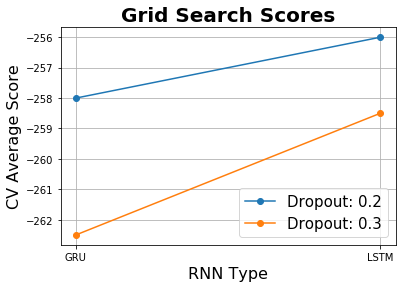

In [17]:
#
# Grid Search / Random Search /  Hyper Parameter Tuning and Cross Validation (Cont.)
#

#
# Display Results
#


# Dropout and RNN Type
PARAM_1 = ('rnn_type', 'RNN Type')
PARAM_2 = ('dropout', 'Dropout')

plot_grid_search(cv_results, SELECTED_SCORER, param_grid[PARAM_1[0]], param_grid[PARAM_2[0]], PARAM_1[1], PARAM_2[1])


In [19]:
#
# Grid Search / Random Search /  Hyper Parameter Tuning and Cross Validation (Cont.)
#

#
# Display Results
#

# Reccurent Dropout and RNN Type
PARAM_1 = ('rnn_type', 'RNN Type')
PARAM_2 = ('recurrent_dropout', 'Reccurent Dropout')

plot_grid_search(cv_results, SELECTED_SCORER, param_grid[PARAM_1[0]], param_grid[PARAM_2[0]], PARAM_1[1], PARAM_2[1])



ValueError: cannot reshape array of size 4 into shape (1,2)

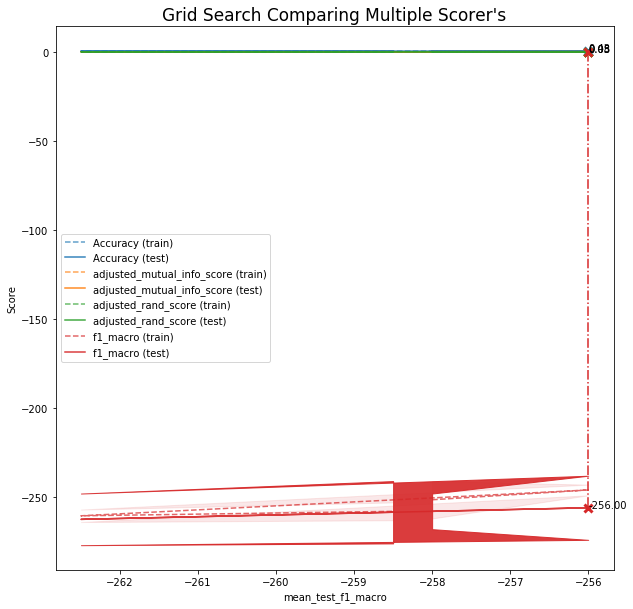

In [21]:
# src:  src: scikitlearn

metric = 'mean_test_%s' %  SELECTED_SCORER 

plt.figure(figsize=(10, 10))
plt.title("Grid Search Comparing Multiple Scorer's",
          fontsize=17)

plt.xlabel(metric)
plt.ylabel("Score")

cmap = plt.get_cmap("tab10")
scoring_colors = [cmap(i) for i in range(len(scoring))]
ax = plt.gca()


X_axis = np.array( cv_results[metric].data, dtype=float )
for scorer, color in zip(sorted(scoring), scoring_colors):

    for sample, style in (('train', '--'), ('test', '-')):
        
        sample_score_mean = cv_results['mean_%s_%s' % (sample, scorer)]
        sample_score_std = cv_results['std_%s_%s' % (sample, scorer)]
        
        ax.fill_between(X_axis, sample_score_mean - sample_score_std,
                        sample_score_mean + sample_score_std,
                        alpha=0.9 if sample == 'test' else 0.1, color=color)
        
        ax.plot(X_axis, sample_score_mean, style, color=color,
                alpha=0.9 if sample == 'test' else 0.7,
                label="%s (%s)" % (scorer, sample))

    best_index = np.nonzero( cv_results['rank_test_%s' % scorer] == 1 )[0][0]
    best_score = cv_results['mean_test_%s' % scorer][best_index]
 
    # Plot a dotted vertical line at the best score for that scorer marked by x
    ax.plot([X_axis[best_index], ] * 2, [0, best_score],
            linestyle='-.', color=color, marker='x', markeredgewidth=3, ms=8)

    # Annotate the best score for that scorer
    ax.annotate("%0.2f" % best_score,
                (X_axis[best_index], best_score + 0.005))

plt.legend(loc="best")
plt.show()

In [30]:
#
# Grid Search / Random Search /  Hyper Parameter Tuning and Cross Validation (Cont.)
#

#
# Summarize Results
#

print("Best: %f using %s" % (grid_search.best_score_, grid_search.best_params_))

mean_test_string = 'mean_test_%s' % SELECTED_SCORER
means = grid_search.cv_results_[mean_test_string]

std_test_string = 'std_test_%s' % SELECTED_SCORER
stds = grid_search.cv_results_[std_test_string]

params = grid_search.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))


Best: -256.000000 using {'loss': 'categorical_crossentropy', 'metrics': ['accuracy'], 'optimizer': 'rmsprop', 'rnn_type': 'LSTM', 'dropout': 0.2, 'embedding_dimensions': 50, 'num_outputs': 5, 'recurrent_dropout': 0.2, 'state_size': 60, 'activation': 'sigmoid'}
-258.000000 (10.000000) with: {'loss': 'categorical_crossentropy', 'metrics': ['accuracy'], 'optimizer': 'rmsprop', 'rnn_type': 'GRU', 'dropout': 0.2, 'embedding_dimensions': 50, 'num_outputs': 5, 'recurrent_dropout': 0.2, 'state_size': 60, 'activation': 'sigmoid'}
-256.000000 (18.000000) with: {'loss': 'categorical_crossentropy', 'metrics': ['accuracy'], 'optimizer': 'rmsprop', 'rnn_type': 'LSTM', 'dropout': 0.2, 'embedding_dimensions': 50, 'num_outputs': 5, 'recurrent_dropout': 0.2, 'state_size': 60, 'activation': 'sigmoid'}
-262.500000 (14.500000) with: {'loss': 'categorical_crossentropy', 'metrics': ['accuracy'], 'optimizer': 'rmsprop', 'rnn_type': 'GRU', 'dropout': 0.3, 'embedding_dimensions': 50, 'num_outputs': 5, 'recurren

In [35]:
#
#
#  Build Two Layer RNN and attach Embedding Layer
#    - Parameters Chosen Based on Search Results
#

from keras.models import Input
from keras.models import Model

NUM_CLASSES = len(bunch.target_names)
tokernizer = glove_embedder.tokenizer
embedding_matrix = glove_embedder.get_embedding_matrix()
#glove_embedder.compute_output_shape()

#
# print best parameters
#

print(best_params)

#
# define two layer model
#

input_holder = Input(shape=(MAXIMUM_ARTICLE_LENGTH,))

x = Embedding(len(tokernizer.word_index) + 1,                      # input dimensions
                EMBEDDING_DIMENSIONS,                              # output dimensions
                input_length=MAXIMUM_ARTICLE_LENGTH)(input_holder) # number of words in each sequence

x = LSTM(best_params['state_size'], dropout=best_params['dropout'], recurrent_dropout=best_params['recurrent_dropout'],return_sequences=True)(x)
x = LSTM(best_params['state_size'], dropout=best_params['dropout'], recurrent_dropout=best_params['recurrent_dropout'])(x)

x = Dense(NUM_CLASSES, activation='softmax')(x)


two_layer_rnn_model = Model(inputs=input_holder, outputs=x)
two_layer_rnn_model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

{'loss': 'categorical_crossentropy', 'metrics': ['accuracy'], 'optimizer': 'rmsprop', 'rnn_type': 'LSTM', 'dropout': 0.2, 'embedding_dimensions': 50, 'num_outputs': 5, 'recurrent_dropout': 0.2, 'state_size': 60, 'activation': 'sigmoid'}


In [37]:
#
# Train Two Layer Model
#

#
# train / test data
# 

X_train, X_test, y_train, y_test = train_test_split(X_enc, y_enc, test_size=TEST_SIZE,
                                                            stratify=bunch.target, 
                                                            random_state=RANDOM_SEED)

history = two_layer_rnn_model.fit(X_train, y_train_ohe, epochs=10, batch_size=250)  # starts training


Epoch 1/10
589/589 [==============================] - 6s 10ms/step - loss: 1.6073 - acc: 0.2903
Epoch 2/10
589/589 [==============================] - 3s 5ms/step - loss: 1.5964 - acc: 0.3599
Epoch 3/10
589/589 [==============================] - 3s 5ms/step - loss: 1.5787 - acc: 0.3599
Epoch 4/10
589/589 [==============================] - 3s 5ms/step - loss: 1.5421 - acc: 0.3599
Epoch 5/10
589/589 [==============================] - 3s 6ms/step - loss: 1.5127 - acc: 0.3599
Epoch 6/10
589/589 [==============================] - 3s 5ms/step - loss: 1.4954 - acc: 0.3599
Epoch 7/10
589/589 [==============================] - 3s 5ms/step - loss: 1.4684 - acc: 0.3599
Epoch 8/10
589/589 [==============================] - 3s 5ms/step - loss: 1.4373 - acc: 0.3599
Epoch 9/10
589/589 [==============================] - 4s 6ms/step - loss: 1.3650 - acc: 0.3786
Epoch 10/10
589/589 [==============================] - 3s 6ms/step - loss: 1.2638 - acc: 0.4329


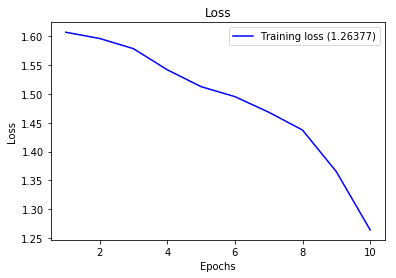

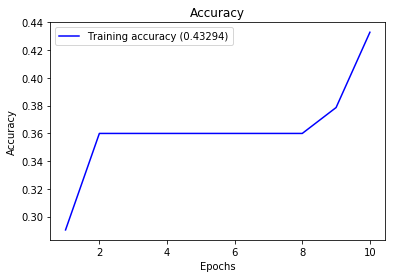

In [39]:
# 
# Display Plot History
#

plot_history(history)